## Mini-batch Stochastic Gradient Descent

  这一算法为随机梯度下降法（Stochastic Gradient Descent）和小批量梯度下降法（Mini-batch Gradient Descent ）的结合。定义为在每轮迭代中随机均匀采样多个样本来组成一个小样本组，然后使用这个小样本组来计算梯度。

In [1]:
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import numpy as np
import time

# 读取数据
data = np.genfromtxt('airfoil_self_noise.dat', delimiter='\t')
# 数据标准化
data = (data - data.mean(axis=0)) / data.std(axis=0)
# 划分训练集和测试集
features = nd.array(data[:1000, :-1])
labels = nd.array(data[:1000, -1])
features_test = nd.array(data[1000:1500, :-1])
labels_test = nd.array(data[1000:1500, -1])

In [2]:
# 定义梯度下降函数
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad
# 定义线性回归函数
def linreg(X, w, b):
    return nd.dot(X, w) + b
# 定义二次回归函数
def  polynomial(X, w, b):
    X_2 = X**2
    X_1 = X
    a = X_2
    b0 = w[: ,0]
    a = nd.array(a)
    b0 = nd.array(b0)
    c = X_1
    d = w[: ,1]
    c = nd.array(c)
    d = nd.array(d)
    t = nd.dot(a,b0)+ nd.dot(c,d) + b
    return t
# 定义平方损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 矢量图函数
def use_svg_display():
    display.set_matplotlib_formats('svg')
# 矢量图设置函数
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

loss: 0.184691, 0.097275 sec per epoch


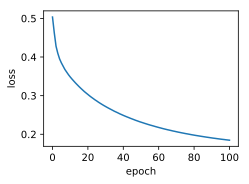

In [3]:
# 模型容量为3
def train_polynomial(trainer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = polynomial, squared_loss
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 2))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    # 梯度下降计算函数
    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()
    # 计算梯度下降
    ls = [eval_loss()]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X, w, b), y).mean()  # 使用平均损失
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    return w,b
def train_sgd_polynomial(lr, batch_size, num_epochs=2):
    w,b = train_polynomial(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
    return w,b
# 梯度为0.001 一个样本组有32个子样本 迭代次数100次
w,b = train_sgd_polynomial(0.001, 32, 100)

上图为使用一次函数拟合结果图

In [4]:
def eval_loss():
    return squared_loss(polynomial(features_test, w, b), labels_test).mean().asscalar()
test_loss = eval_loss()
print("test_loss: ",test_loss)

test_loss:  0.36461166


loss: 0.190412, 0.056877 sec per epoch


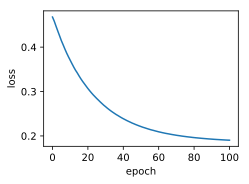

In [5]:
# 模型容量为4
def train_linreg(trainer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss    
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    # 梯度下降计算函数
    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()

    ls = [eval_loss()]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X, w, b), y).mean()  # 使用平均损失
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    return w,b
def train_sgd_linreg(lr, batch_size, num_epochs=2):
    w,b = train_linreg(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
    return w,b
# 梯度为0.001 一个样本组有32个子样本 迭代次数100次
w,b = train_sgd_linreg(0.001, 32, 100)

上图为使用二次函数拟合结果图

In [6]:
def eval_loss():
    return squared_loss(linreg(features_test, w, b), labels_test).mean().asscalar()
test_loss = eval_loss()
print("test_loss: ",test_loss)

test_loss:  0.36058348
